# DAPT 612: Text Mining
## Assignment 2
Group 3: Brie Dubinsky, Aaron Clark, Aastha Malhotra, Bindhya Neupane, Kate Loomis

In [24]:
from collections import OrderedDict
import csv
# from elasticsearch import helpers, Elasticsearch as es
import en_core_web_sm
#import gensim.downloader as gensim_api
#import gensim
# import langdetect
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
import numpy as np
import os
import pandas as pd
#from pprint import pprint
import re
import requests
#from sklearn import feature_extraction, manifold
import spacy
#from spacy.matcher import Matcher
import string
from textblob import TextBlob
import texthero as hero
import textacy
from textacy import preprocessing, extract
import seaborn as sns
import wordcloud
#from wordcloud import STOPWORDS
nlp = en_core_web_sm.load()
#matcher = Matcher(nlp.vocab)

# LOCAL_REPOSITORY_LOCATION = os.environ.get('LOCAL_REPOSITORY_LOCATION')
# os.chdir(r'C:\Users\short\Documents\LOCAL_REPOSITORY_LOCATION\612_TextMining')
# print(os.getcwdb())

#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

In [25]:
# read in the file
df1 = pd.read_csv('eval_data_dapt.csv', encoding = 'utf-8', dtype = str)

# read in the lookup values
df2 = pd.read_excel(r'competency_definitions.xlsx', sheet_name = 0)

df3 = pd.merge(df1, df2, on = 'epa_number', how = 'left')

df3 = df3[['eval_id', 'student_id', 'gender', 'course', 'preceptor', 'epa_number', 'display_label', 'rating_score', 'rating_label', 'comments']]

data = df3.copy(deep = False)

data.head(1)

eval_id student_id gender      course  preceptor epa_number  \
0   55339        855      M  Pediatrics  Attending      EPA 1   

                                       display_label rating_score  \
0  Gather a History and Perform a Physical Examin...            3   

                             rating_label  \
0  I had to prompt them from time to time   

                                            comments  
0  Work on your interview structure. Keep it cons...

# Description of the data set
This dataset represents a behavioral assessment of medical student clinical performance. Students receive these evaluations once a week from the supervising physicians who teach them. This assessment is similar to a workplace-based assessment (WBA) and provides students with a real-time understanding of their performance on 13 core clinical skills (<a href="https://www.aamc.org/what-we-do/mission-areas/medical-education/cbme/core-epas">entrustable professional activities</a>). The evaluation utilizes a modified version of the Ottawa Clinic Assessment Scale (<a href="https://pubmed.ncbi.nlm.nih.gov/27052202/">OCAT</a>) to describe the student's readiness for independent practice. In this dataset, the rating values range from 1 (_I had to do it for them_) to 5 (_I did not need to be there_).

In [28]:
data.head(3)

eval_id student_id gender      course  preceptor epa_number  \
0   55339        855      M  Pediatrics  Attending      EPA 1   
1   55453        855      M  Pediatrics  Attending      EPA 6   
2   56658        855      M  Pediatrics  Attending      EPA 2   

                                       display_label rating_score  \
0  Gather a History and Perform a Physical Examin...            3   
1  Provide an Oral Presentation of a Clinical Enc...            3   
2  Prioritize a Differential Diagnosis Following ...            4   

                             rating_label  \
0  I had to prompt them from time to time   
1  I had to prompt them from time to time   
2   I needed to be available just in case   

                                            comments  
0  Work on your interview structure. Keep it cons...  
1  Develop ED focused presentation skills by pres...  
2          Watch as many physical exams as possible

In [29]:
data['epa_number'].unique()

array(['EPA 1', 'EPA 6', 'EPA 2', 'EPA 3', 'EPA 5', 'EPA 9', 'EPA 7',
       'EPA 8', 'EPA 4', 'EPA 11', 'EPA 13', 'EPA 10', 'EPA 12'],
      dtype=object)

In [30]:
data['display_label'].unique()

array(['Gather a History and Perform a Physical Examination',
       'Provide an Oral Presentation of a Clinical Encounter',
       'Prioritize a Differential Diagnosis Following a Clinical Encounter',
       'Recommend and Interpret Common Diagnostic and Screening Tests',
       'Document a Clinical Encounter in the Patient Record',
       'Collaborate as a Member of an Interprofessional Team',
       'Form Clinical Questions and Retrieve Evidence to Advance Patient Care',
       'Give or Receive a Patient Handover to Transition Care Responsibility',
       'Enter and Discuss Orders and Prescriptions',
       'Obtain Informed Consent for Tests and/or Procedures',
       'Identify System Failures and Contribute to a Culture of Safety and Improvement',
       'Recognize a Patient Requiring Urgent or Emergent Care and Initiate Evaluation and Management',
       'Perform General Procedures of a Physician'], dtype=object)

## Manual pre-processing steps:

 - **Student:** I converted student names to lowercase.
 -  **Course:** I replaced a compound name (`Obstetrics & Gynecology`) with a short name (`Obstetrics`) to improve sorting/tagging.

In [31]:
data['course'] = (data['course'].str.replace('Obstetrics & Gynecology', 'Obstetrics'))

I created a custom pipeline in TextHero that:

 - removes whitespace between words
 - removes common stopwords
 - removes punctuation, diacritics, and digits
 - drops empty rows

I will apply this later, after exploring the raw data further. 

In [34]:
from texthero import preprocessing

custom_pipeline = [preprocessing.remove_whitespace,
                   preprocessing.remove_stopwords,
                   preprocessing.remove_diacritics,
                   preprocessing.remove_punctuation, #potentially remove later (to segregate sentences)
                   preprocessing.remove_digits,
                   preprocessing.drop_no_content,
                   preprocessing.lowercase]

There are eight core specialties represented in the dataset:

In [35]:
data['course'].unique()

array(['Pediatrics', 'Obstetrics', 'Neurology', 'Psychiatry',
       'Ambulatory', 'Family Medicine', 'Surgery', 'Internal Medicine'],
      dtype=object)

Students receive instruction from supervising senior physicians (attendings), physicians pursuing specialized post-graduate training (residents), and various members of the healthcare team (e.g., nurses).

In [36]:
data.preceptor.unique()

array(['Attending', 'Resident', 'Other'], dtype=object)

# Descriptive statistics

There are 1,240 observations in the dataset, representing evaluations on 22 students. It's interesting that the most frequent comment in the dataset is "no comments," because comments are recorded in a free-text field (i.e., there are no "canned" or pre-populated options). Given the busy pace of work in the hospital, and the high volume of required paperwork they must also complete, this is understandable though not ideal.

In [37]:
data.describe()

eval_id student_id gender             course  preceptor epa_number  \
count     1240       1240   1240               1240       1240       1240   
unique    1240         23      2                  8          3         13   
top      55339       1006      M  Internal Medicine  Attending      EPA 1   
freq         1         82    798                233        596        299   

                                            display_label rating_score  \
count                                                1240         1240   
unique                                                 13            5   
top     Gather a History and Perform a Physical Examin...            4   
freq                                                  299          641   

                                 rating_label     comments  
count                                    1240         1240  
unique                                      5         1120  
top     I needed to be available just in case  No comments  
freq                                      641           38

I was curious to see whether the ratings aligned with qualitative feedback, as most evaluations rate students at a 4 or higher. A small sample reveals some room for improvement and a few common typos. For example, one physician used the shorthand for "patient" ("pt") when perhaps they're referring to the student (StudentID 855). 

In [38]:
data[data['rating_score'] == '5'].head()

eval_id student_id gender      course  preceptor epa_number  \
12   77699        855      M   Neurology  Attending      EPA 6   
15   83903        855      M  Psychiatry   Resident      EPA 2   
16   83904        855      M  Psychiatry   Resident      EPA 2   
17   85335        855      M  Psychiatry   Resident      EPA 7   
19   85978        855      M  Psychiatry   Resident      EPA 1   

                                        display_label rating_score  \
12  Provide an Oral Presentation of a Clinical Enc...            5   
15  Prioritize a Differential Diagnosis Following ...            5   
16  Prioritize a Differential Diagnosis Following ...            5   
17  Form Clinical Questions and Retrieve Evidence ...            5   
19  Gather a History and Perform a Physical Examin...            5   

                  rating_label  \
12  I did not need to be there   
15  I did not need to be there   
16  I did not need to be there   
17  I did not need to be there   
19  I did not need to be there   

                                             comments  
12  Pt would easily become independent with additi...  
15                                   Doing a good job  
16                                   Doing a good job  
17                         continuing to do good work  
19                   Very thorough. Doing a great job

## Checking for missing values

We don't have any missing values in this data set, which simplifies some steps for cleaning.

In [42]:
data.isna().sum()

eval_id          0
student_id       0
gender           0
course           0
preceptor        0
epa_number       0
display_label    0
rating_score     0
rating_label     0
comments         0
dtype: int64

# Are students evaluated more often in some competencies than others?
There seems to be a preference for evaluating students in their history and physical exam (EPA 1), oral presentations (EPA 6), clinical documentation (EPA 5), and differential diagnosis (EPA 2). This makes sense, because many of the less utilized competencies represent complex tasks that students may not be authorized to perform in every setting.

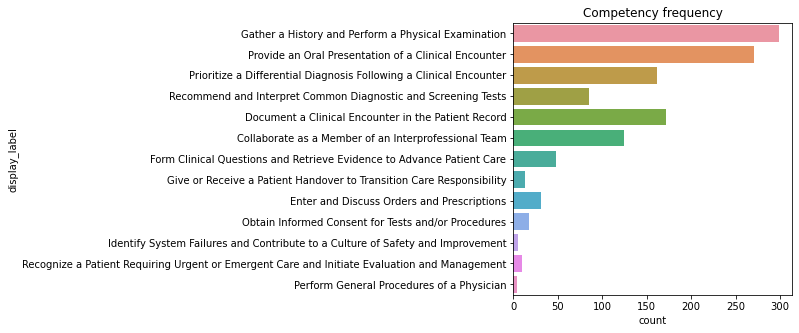

In [43]:
total = len(data)

plt.figure(figsize = (5, 5))
plt.title('Competency frequency')
ax = sns.countplot(y = 'display_label', data = data)
for p in ax.patches:
    percentage = '{0:.0f}%'.format(p.get_height() / total * 100)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 20
    ax.annotate(percentage, (x, y), ha = 'center')
plt.show()

# KL Average Word Counts by Ratings / Preceptor

In [232]:
df3 = data[['eval_id', 'student_id', 'gender', 
            'course', 'preceptor', 'epa_number', 
            'display_label', 'rating_score', 'rating_label', 
            'comments']]

In [234]:
df3['comments'] = hero.clean(df3['comments'], custom_pipeline)

C:\Users\clark\AppData\Local\Temp/ipykernel_15348/50138379.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [244]:
df3['count'] = df3['comments'].str.split().str.len()

df3.head(1)

C:\Users\clark\AppData\Local\Temp/ipykernel_15348/1044068756.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



eval_id student_id gender      course  preceptor epa_number  \
0   55339        855      M  Pediatrics  Attending      EPA 1   

                                       display_label rating_score  \
0  Gather a History and Perform a Physical Examin...            3   

                             rating_label  \
0  I had to prompt them from time to time   

                                            comments  count  
0  work   interview structure  keep  consistent  ...     19

In [245]:
pd.options.display.float_format = '{:.5}'.format
df3.groupby('rating_score')['count'].mean()


rating_score
1   15.667
2   14.556
3    16.83
4   11.126
5   7.9668
Name: count, dtype: float64

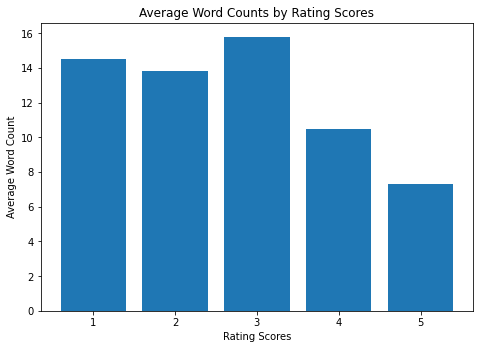

In [247]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
rating_scores = ['1', '2', '3', '4', '5']
Average_Word_Counts = [14.50,13.85,15.82,10.46,7.30]
ax.bar(rating_scores,Average_Word_Counts)
ax.set_ylabel('Average Word Count')
ax.set_xlabel('Rating Scores')
ax.set_title('Average Word Counts by Rating Scores')
plt.show()

In [248]:
df3.groupby('rating_score')['count'].min()

rating_score
1    5
2    4
3    1
4    1
5    1
Name: count, dtype: int64

In [249]:
df3.groupby('rating_score')['count'].max()

rating_score
1     26
2     36
3    176
4    149
5     70
Name: count, dtype: int64

In [279]:
# Average number of words per rating score by preceptor
dft = df3.groupby(['preceptor', 'rating_score'])['count'].mean()

dfs = pd.DataFrame(dft)
dfs.reset_index(inplace = True)

dfs

preceptor rating_score  count
0   Attending            1   10.0
1   Attending            2   21.5
2   Attending            3   18.0
3   Attending            4   12.8
4   Attending            5   10.9
5       Other            3    3.5
6       Other            4   3.77
7       Other            5   4.13
8    Resident            1   21.3
9    Resident            2   11.6
10   Resident            3   17.2
11   Resident            4   11.1
12   Resident            5   8.64

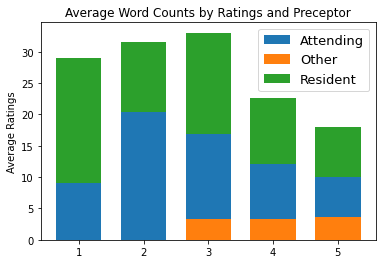

In [251]:
labels = ['1', '2', '3', '4', '5']
attending_means = [9.00, 20.38, 16.86, 12.14, 10.05]
other_means = [0, 0, 3.28, 3.25, 3.64]
resident_means = [20.00, 11.11, 16.19, 10.44, 8.03]
width = 0.7      # adjusts the width of the bars

fig, ax = plt.subplots()

ax.bar(labels, attending_means, width, label='Attending')
ax.bar(labels, other_means, width, label='Other')
ax.bar(labels, resident_means, width, bottom=attending_means, label='Resident')


ax.set_ylabel('Average Ratings')
ax.set_title('Average Word Counts by Ratings and Preceptor')
ax.legend()
plt.legend(prop={"size":13})

plt.show()

In [252]:
df3.groupby(['course', 'rating_score'])['count'].mean()

course             rating_score
Ambulatory         3              10.933
                   4              9.9524
                   5              12.362
Family Medicine    1                 5.0
                   3              5.3636
                   4              4.4605
                   5              3.9213
Internal Medicine  2              15.417
                   3               23.88
                   4              17.992
                   5              10.558
Neurology          1                18.0
                   2              13.667
                   3              17.875
                   4              8.6585
                   5              8.7333
Obstetrics         1                 7.0
                   2                14.0
                   3               13.68
                   4              10.395
                   5              11.889
Pediatrics         2                18.5
                   3              22.031
                   4     

In [276]:
agg_df3 = df3.groupby(['rating_score', 'course'])['count'].mean().unstack().fillna(0)

pd.options.display.float_format = '{:.3}'.format

agg_df3



course        Ambulatory  Family Medicine  Internal Medicine  Neurology  \
rating_score                                                              
1                    0.0              5.0                0.0       18.0   
2                    0.0              0.0               15.4       13.7   
3                   10.9             5.36               23.9       17.9   
4                   9.95             4.46               18.0       8.66   
5                   12.4             3.92               10.6       8.73   

course        Obstetrics  Pediatrics  Psychiatry  Surgery  
rating_score                                               
1                    7.0         0.0         0.0     21.3  
2                   14.0        18.5        13.2     12.5  
3                   13.7        22.0        17.1     14.2  
4                   10.4        11.0        11.0     9.36  
5                   11.9        11.0        8.08     4.18

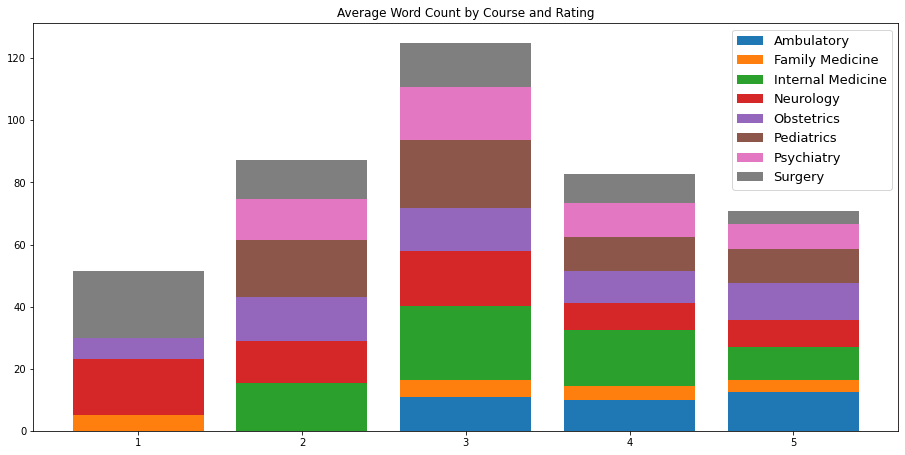

In [254]:
fig, ax = plt.subplots()

# Initialize the bottom at zero for the first set of bars.
bottom = np.zeros(len(agg_df3))

# Plot each layer of the bar, adding each bar to the "bottom" so
# the next bar starts higher.
for i, col in enumerate(agg_df3.columns):
  ax.bar(agg_df3.index, agg_df3[col], bottom=bottom, label=col)
  bottom += np.array(agg_df3[col])

ax.set_title('Average Word Count by Course and Rating')
ax.legend()
plt.legend(prop={"size":13})
fig.set_size_inches(15.5, 7.5)

# Visualize the comments in a word cloud

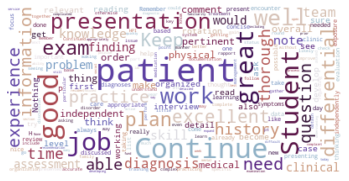

In [44]:
# https://amueller.github.io/word_cloud/auto_examples/simple.html
# https://www.python-graph-gallery.com/wordcloud/
# https://towardsdatascience.com/how-to-create-beautiful-word-clouds-in-python-cfcf85141214

from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')
from wordcloud import WordCloud, STOPWORDS

# collect the comments
comment = " ".join(comment for comment in data.comments)
wordcloud = WordCloud(max_font_size = 40,
                      collocations = False, 
                      stopwords = stopwords,
                      margin = 0, 
                      background_color = 'white', 
                      colormap = 'twilight').generate(comment)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()

Based on the information visualized in the wordcloud, I decided to incorporate key words, like "patient" and "student" into the list of stopwords.

In [45]:
wn = nltk.WordNetLemmatizer()

# Create function for text cleaning 
def clean_text(text):
    text = ''.join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.findall('\S+', text)
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords] 
    return text

data['words'] = data['comments'].apply(lambda x: clean_text(str(x)))

# Define extra stopwords
extra_stopwords = ['history', 'h', 'p', 'sure', 'well', 'patient', 'student', 'exam', 'make']

# Remove extra stopwords  
data.loc[:,'words'] = data['words'].apply(lambda x: [word for word in x if word not in extra_stopwords])

In [46]:
data[['comments', 'words']].head(5)

comments  \
0  Work on your interview structure. Keep it cons...   
1  Develop ED focused presentation skills by pres...   
2          Watch as many physical exams as possible    
3  Should work on being more methodical in collec...   
4  Did well reorganizing the assessment by proble...   

                                               words  
0  [work, interview, structure, keep, consistent,...  
1  [develop, ed, focused, presentation, skill, pr...  
2                  [watch, many, physical, possible]  
3  [work, methodical, collecting, information, pr...  
4  [reorganizing, assessment, problem, plan, prob...

As I experimented with various NLP packages, I opted to preserve the "raw comments" and added a new column for comments I passed through the TextHero preprocessing pipleline.

In [47]:
data['comments_clean'] = data['comments']

# clean the comments but preserve the original comments
data['comments_clean'] = hero.clean(data['comments_clean'], custom_pipeline)

data.head(10)

eval_id student_id gender      course  preceptor epa_number  \
0   55339        855      M  Pediatrics  Attending      EPA 1   
1   55453        855      M  Pediatrics  Attending      EPA 6   
2   56658        855      M  Pediatrics  Attending      EPA 2   
3   57949        855      M  Pediatrics  Attending      EPA 3   
4   62690        855      M  Pediatrics  Attending      EPA 5   
5   62692        855      M  Pediatrics  Attending      EPA 9   
6   63905        855      M  Obstetrics  Attending      EPA 9   
7   64208        855      M  Obstetrics   Resident      EPA 6   
8   65824        855      M  Obstetrics  Attending      EPA 6   
9   68077        855      M  Obstetrics   Resident      EPA 7   

                                       display_label rating_score  \
0  Gather a History and Perform a Physical Examin...            3   
1  Provide an Oral Presentation of a Clinical Enc...            3   
2  Prioritize a Differential Diagnosis Following ...            4   
3  Recommend and Interpret Common Diagnostic and ...            3   
4  Document a Clinical Encounter in the Patient R...            3   
5  Collaborate as a Member of an Interprofessiona...            4   
6  Collaborate as a Member of an Interprofessiona...            3   
7  Provide an Oral Presentation of a Clinical Enc...            3   
8  Provide an Oral Presentation of a Clinical Enc...            3   
9  Form Clinical Questions and Retrieve Evidence ...            3   

                             rating_label  \
0  I had to prompt them from time to time   
1  I had to prompt them from time to time   
2   I needed to be available just in case   
3  I had to prompt them from time to time   
4  I had to prompt them from time to time   
5   I needed to be available just in case   
6  I had to prompt them from time to time   
7  I had to prompt them from time to time   
8  I had to prompt them from time to time   
9  I had to prompt them from time to time   

                                            comments  \
0  Work on your interview structure. Keep it cons...   
1  Develop ED focused presentation skills by pres...   
2          Watch as many physical exams as possible    
3  Should work on being more methodical in collec...   
4  Did well reorganizing the assessment by proble...   
5  I think it's great to get involved with what p...   
6  Present, scrubbed and engaged for a hysterecto...   
7  Needs to work on physical exam skills and orga...   
8  This was a presentation for a case based teach...   
9             Doing just fine for a new third year.    

                                               words  \
0  [work, interview, structure, keep, consistent,...   
1  [develop, ed, focused, presentation, skill, pr...   
2                  [watch, many, physical, possible]   
3  [work, methodical, collecting, information, pr...   
4  [reorganizing, assessment, problem, plan, prob...   
5  [think, great, get, involved, physical, therap...   
6  [present, scrubbed, engaged, hysterectomy, ask...   
7  [need, work, physical, skill, organizing, pres...   
8  [presentation, case, based, teaching, conferen...   
9                           [fine, new, third, year]   

                                      comments_clean  
0  work   interview structure  keep  consistent  ...  
1  develop ed focused presentation skills  presen...  
2               watch  many physical exams  possible  
3  should work    methodical  collecting informat...  
4  did well reorganizing  assessment  problem   p...  
5  i think   great  get involved   physical thera...  
6  present  scrubbed  engaged   hysterectomy  ask...  
7  needs  work  physical exam skills  organizing ...  
8  this   presentation   case based teaching conf...  
9                      doing  fine   new third year

# Visualizing top words associated with high/low evaluation ratings

Text(0.5, 1.0, 'Words used often in evaluations with high ratings')

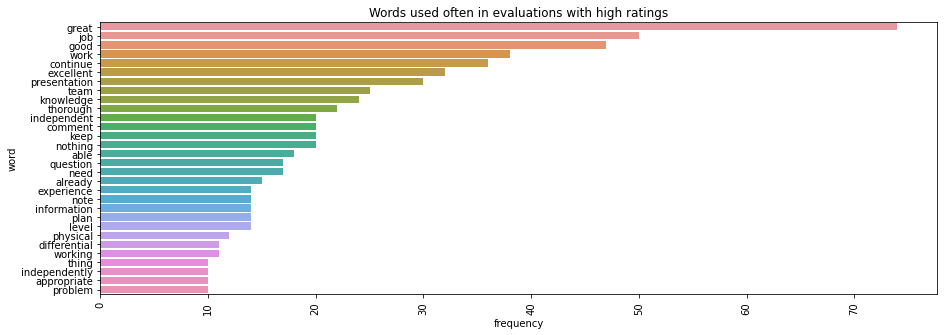

In [48]:
from collections import Counter

high_rating = list(data.loc[data.rating_score == '5', 'words'])

# Flatten list of lists
high_rating = list(np.concatenate(high_rating).flat)

# Create dictionary to store word frequency
high_rating = Counter(high_rating)
hr_words = pd.DataFrame(high_rating.most_common(30), columns = ['word', 'frequency'])

# plot most common words related to the H&P competency
fig, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x = 'frequency', y = 'word', data = hr_words, ax = ax)
plt.xticks(rotation = '90')
plt.title('Words used often in evaluations with high ratings')

The results make sense, given that lower ratings indicate that the student's skills are developing. Words like _continue_ and _practice_ reflect this.

Text(0.5, 1.0, 'Words used often in evaluations with low ratings')

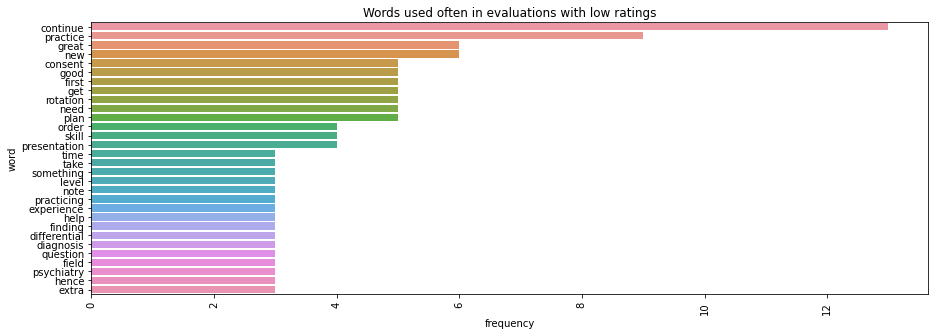

In [49]:
low_rating = list(data.loc[data.rating_score < '3', 'words'])

# Flatten list of lists
low_rating = list(np.concatenate(low_rating).flat)

# Create dictionary to store word frequency
low_rating = Counter(low_rating)
lr_words = pd.DataFrame(low_rating.most_common(30), columns = ['word', 'frequency'])

# plot most common words related to the H&P competency
fig, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x = 'frequency', y = 'word', data = lr_words, ax = ax)
plt.xticks(rotation = '90')
plt.title('Words used often in evaluations with low ratings')

In [259]:
hr_words.head(10)

word  frequency
0         great         74
1           job         50
2          good         47
3          work         38
4      continue         36
5     excellent         32
6  presentation         30
7          team         25
8     knowledge         24
9      thorough         22

# Visualizing top words associated evaluation ratings by GENDER

In [219]:
# female & male df's:
dff = data[data.gender == 'F']
dfm = data[data.gender == 'M']

#female & male / high & low scores df's:
dffh = data[(data.gender == 'F') & (data.rating_score == '5')]
dffl = data[(data.gender == 'F') & (data.rating_score < '3')]

dfmh = data[(data.gender == 'M') & (data.rating_score == '5')]
dfml = data[(data.gender == 'M') & (data.rating_score < '3')]

In [220]:
# WORD COUNTER: FEMALES (ALL SCORES)

from collections import Counter
words_f = list(dff.words)

# Flatten list of lists
words_f = list(np.concatenate(words_f).flat)

# Create dictionary to store word frequency
words_f = Counter(words_f)
words_f2 = pd.DataFrame(words_f.most_common(30), columns = ['word', 'frequency'])




# WORD COUNTER: MALES (ALL SCORES)

words_m = list(dfm.words)

# Flatten list of lists
words_m = list(np.concatenate(words_m).flat)

# Create dictionary to store word frequency
words_m = Counter(words_m)
words_m2 = pd.DataFrame(words_m.most_common(30), columns = ['word', 'frequency'])




# WORD COUNTER: FEMALES (HIGH SCORES)

words_fh = list(dffh.words)

# Flatten list of lists
words_fh = list(np.concatenate(words_fh).flat)

# Create dictionary to store word frequency
words_fh = Counter(words_fh)
words_fh2 = pd.DataFrame(words_fh.most_common(30), columns = ['word', 'frequency'])





# WORD COUNTER: MALES (HIGH SCORES)

words_mh = list(dfmh.words)

# Flatten list of lists
words_mh = list(np.concatenate(words_mh).flat)

# Create dictionary to store word frequency
words_mh = Counter(words_mh)
words_mh2 = pd.DataFrame(words_mh.most_common(30), columns = ['word', 'frequency'])





# WORD COUNTER: FEMALES (LOW SCORES)

words_fl = list(dffl.words)

# Flatten list of lists
words_fl = list(np.concatenate(words_fl).flat)

# Create dictionary to store word frequency
words_fl = Counter(words_fl)
words_fl2 = pd.DataFrame(words_fl.most_common(30), columns = ['word', 'frequency'])




# WORD COUNTER: MALES (LOW SCORES)

words_ml = list(dfml.words)

# Flatten list of lists
words_ml = list(np.concatenate(words_ml).flat)

# Create dictionary to store word frequency
words_ml = Counter(words_ml)
words_ml2 = pd.DataFrame(words_ml.most_common(30), columns = ['word', 'frequency'])

Text(0.5, 1.0, 'MALES: Words used often in LOW RATING evaluations (male students: 798)')

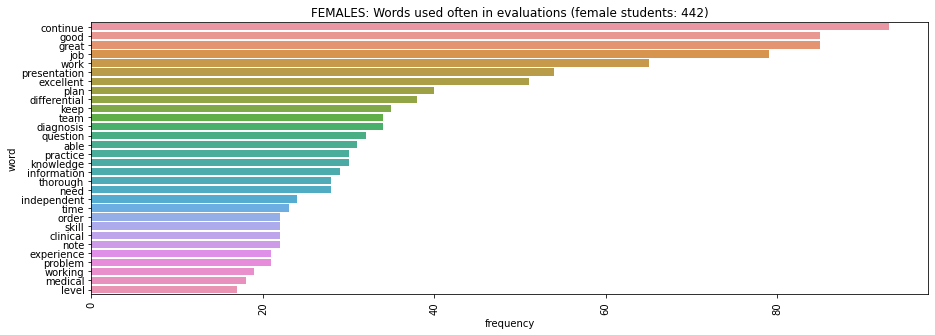

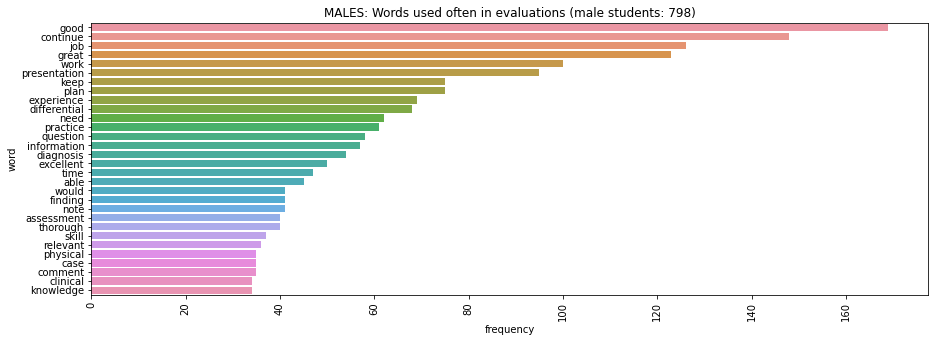

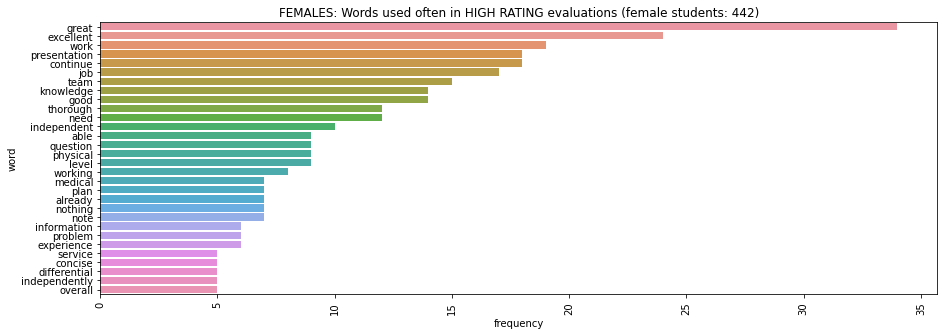

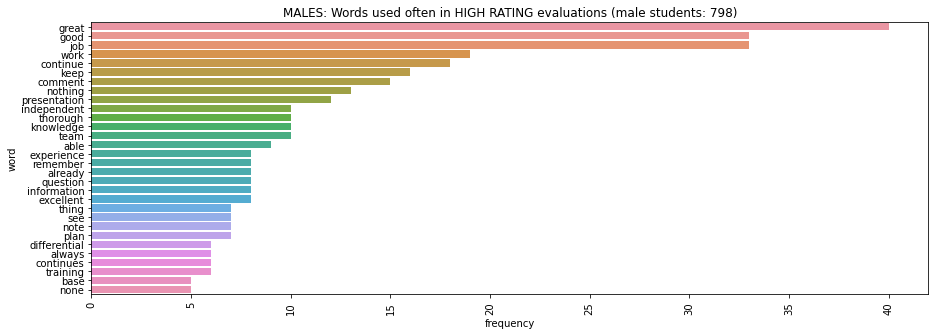

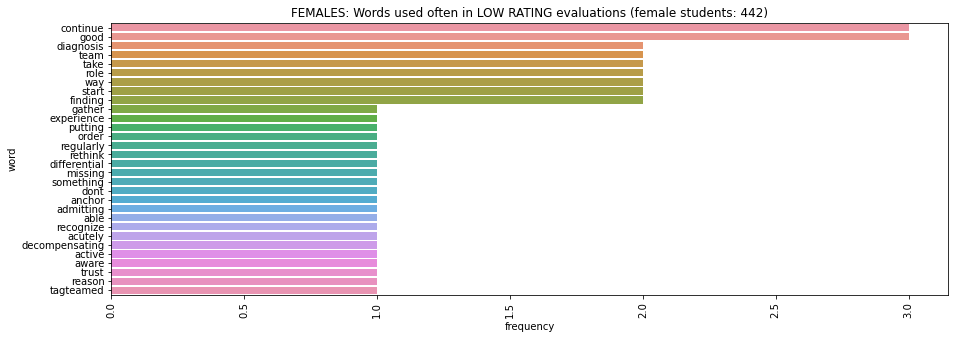

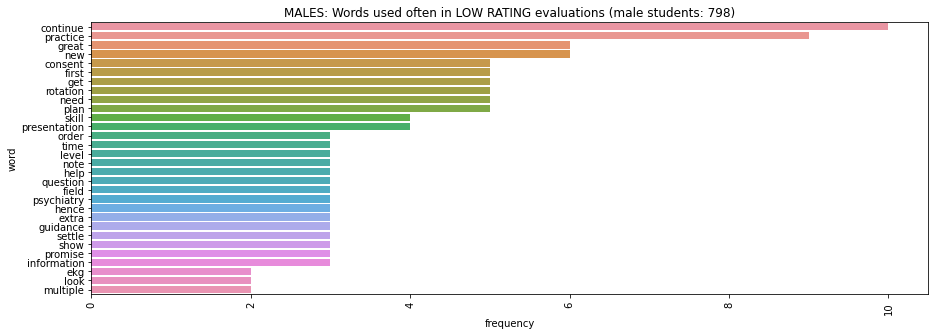

In [221]:
# PLOT MOST COMMON WORDS related to the H&P competency
n_females_eval = dff.gender.count()
n_males_eval = dfm.gender.count()



# females all scores
fig, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x = 'frequency', y = 'word', data = words_f2, ax = ax)
plt.xticks(rotation = '90')
plt.title(f'FEMALES: Words used often in evaluations (female students: {n_females_eval})')



# males all scores
fig, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x = 'frequency', y = 'word', data = words_m2, ax = ax)
plt.xticks(rotation = '90')
plt.title(f'MALES: Words used often in evaluations (male students: {n_males_eval})')



#females high scores
fig, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x = 'frequency', y = 'word', data = words_fh2, ax = ax)
plt.xticks(rotation = '90')
plt.title(f'FEMALES: Words used often in HIGH RATING evaluations (female students: {n_females_eval})')



#males high scores
fig, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x = 'frequency', y = 'word', data = words_mh2, ax = ax)
plt.xticks(rotation = '90')
plt.title(f'MALES: Words used often in HIGH RATING evaluations (male students: {n_males_eval})')



#females low scores
fig, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x = 'frequency', y = 'word', data = words_fl2, ax = ax)
plt.xticks(rotation = '90')
plt.title(f'FEMALES: Words used often in LOW RATING evaluations (female students: {n_females_eval})')



#males low scores
fig, ax = plt.subplots(figsize = (15, 5))
sns.barplot(x = 'frequency', y = 'word', data = words_ml2, ax = ax)
plt.xticks(rotation = '90')
plt.title(f'MALES: Words used often in LOW RATING evaluations (male students: {n_males_eval})')

In [222]:
# capture 100 most common words in evaluations from each gender, HIGH & LOW rating evals

# top 100 words from ALL evals
words_f3 = pd.DataFrame(words_f.most_common(100), columns = ['word', 'frequency'])
words_m3 = pd.DataFrame(words_m.most_common(100), columns = ['word', 'frequency'])



# top 100 words from HIGH evals
words_fh3 = pd.DataFrame(words_fh.most_common(100), columns = ['word', 'frequency'])
words_mh3 = pd.DataFrame(words_mh.most_common(100), columns = ['word', 'frequency'])



# top 100 words from LOW evals
words_fl3 = pd.DataFrame(words_fl.most_common(100), columns = ['word', 'frequency'])
words_ml3 = pd.DataFrame(words_ml.most_common(100), columns = ['word', 'frequency'])

In [224]:
# rank top words for each gender ALL evals

words_f3['rank_f'] = words_f3.frequency.rank(method = 'dense', ascending = False)
words_m3['rank_m'] = words_m3.frequency.rank(method = 'dense', ascending = False)

# merge top female & top male words ALL evals
words_fm = pd.merge(words_f3, words_m3, on = 'word', how = 'outer')

# rename columns (female/male) ALL evals
words_fm.rename(columns = {'frequency_x': 'female_freq', 'frequency_y':'male_freq'}, inplace = True)

words_fm.head()

word  female_freq  rank_f  male_freq  rank_m
0  continue         93.0     1.0      148.0     2.0
1      good         85.0     2.0      169.0     1.0
2     great         85.0     2.0      123.0     4.0
3       job         79.0     3.0      126.0     3.0
4      work         65.0     4.0      100.0     5.0

In [225]:
# rank top words for each gender HIGH SCORE evals
words_fh3['rank_f'] = words_fh3.frequency.rank(method = 'dense', ascending = False)
words_mh3['rank_m'] = words_mh3.frequency.rank(method = 'dense', ascending = False)

# merge top female & top male words HIGH SCORE evals
words_fmh = pd.merge(words_fh3, words_mh3, on = 'word', how = 'outer')

# rename columns (female/male) HIGH evals
words_fmh.rename(columns = {'frequency_x': 'female_freq', 'frequency_y':'male_freq'}, inplace = True)

words_fmh.head() 

word  female_freq  rank_f  male_freq  rank_m
0         great         34.0     1.0       40.0     1.0
1     excellent         24.0     2.0        8.0    11.0
2          work         19.0     3.0       19.0     3.0
3  presentation         18.0     4.0       12.0     8.0
4      continue         18.0     4.0       18.0     4.0

In [226]:
# rank top words for each gender LOW SCORE evals
words_fl3['rank_f'] = words_fl3.frequency.rank(method = 'dense', ascending = False)
words_ml3['rank_m'] = words_ml3.frequency.rank(method = 'dense', ascending = False)

# merge top female & top male words LOW SCORE evals
words_fml = pd.merge(words_fl3, words_ml3, on = 'word', how = 'outer')

# rename columns (female/male) LOW evals
words_fml.rename(columns = {'frequency_x': 'female_freq', 'frequency_y':'male_freq'}, inplace = True)

words_fml.head()

word  female_freq  rank_f  male_freq  rank_m
0   continue          3.0     1.0       10.0     1.0
1       good          3.0     1.0        2.0     7.0
2  diagnosis          2.0     2.0        NaN     NaN
3       team          2.0     2.0        NaN     NaN
4       take          2.0     2.0        1.0     8.0

Words in top 100 most common words from ALL evaluations that are unique to FEMALES


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



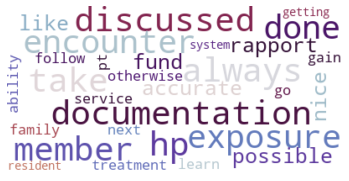

Words in top 100 most common words from ALL evaulations that are unique to MALES


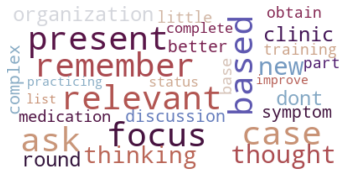

In [227]:
# common & unique words between female / male students ALL evals

common = words_fm[(words_fm.female_freq.notnull()) & (words_fm.male_freq.notnull())]
unique = words_fm[(words_fm.female_freq.isna()) | (words_fm.male_freq.isna())]
unique_f = unique[unique.female_freq.notnull()]
unique_m = unique[unique.male_freq.notnull()]

unique_f.drop(columns = ['male_freq', 'rank_m'], inplace = True)
unique_m.drop(columns = ['female_freq', 'rank_f'], inplace = True)

# word clouds 

from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')
from wordcloud import WordCloud, STOPWORDS

# Words unique to FEMALES' evaluations (in most 100 common words) ALL EVALS

comment = " ".join(comment for comment in unique_f.word)
wordcloud = WordCloud(max_font_size = 40,
                      collocations = False, 
                      stopwords = stopwords,
                      margin = 0, 
                      background_color = 'white', 
                      colormap = 'twilight').generate(comment)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
print('Words in top 100 most common words from ALL evaluations that are unique to FEMALES')
plt.show()

# Words unique to MALES' evaluations (in most 100 common words) ALL EVALS

comment = " ".join(comment for comment in unique_m.word)
wordcloud = WordCloud(max_font_size = 40,
                      collocations = False, 
                      stopwords = stopwords,
                      margin = 0, 
                      background_color = 'white', 
                      colormap = 'twilight').generate(comment)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
print('Words in top 100 most common words from ALL evaulations that are unique to MALES')
plt.show()

Words in top 100 most common words from HIGH SCORING evaluations that are unique to FEMALES


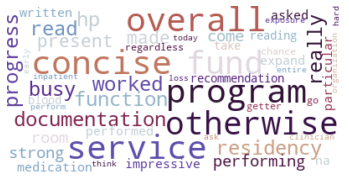

Words in top 100 most common words from HIGH SCORING evaulations that are unique to MALES


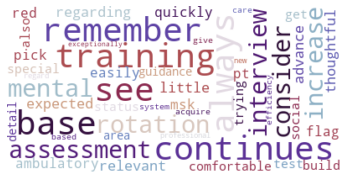

In [228]:
# common & unique words between female / male students HIGH evals

commonh = words_fmh[(words_fmh.female_freq.notnull()) & (words_fmh.male_freq.notnull())]
uniqueh = words_fmh[(words_fmh.female_freq.isna()) | (words_fmh.male_freq.isna())]
unique_fh = uniqueh[uniqueh.female_freq.notnull()]
unique_mh = uniqueh[uniqueh.male_freq.notnull()]

unique_fh.drop(columns = ['male_freq', 'rank_m'], inplace = True)
unique_mh.drop(columns = ['female_freq', 'rank_f'], inplace = True)

unique_fh.head()
unique_mh.head()

# Words unique to FEMALES' evaluations (in most 100 common words) HIGH EVALS

comment = " ".join(comment for comment in unique_fh.word)
wordcloud = WordCloud(max_font_size = 40,
                      collocations = False, 
                      stopwords = stopwords,
                      margin = 0, 
                      background_color = 'white', 
                      colormap = 'twilight').generate(comment)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
print('Words in top 100 most common words from HIGH SCORING evaluations that are unique to FEMALES')
plt.show()

# Words unique to MALES' evaluations (in most 100 common words) HIGH EVALS
comment = " ".join(comment for comment in unique_mh.word)
wordcloud = WordCloud(max_font_size = 40,
                      collocations = False, 
                      stopwords = stopwords,
                      margin = 0, 
                      background_color = 'white', 
                      colormap = 'twilight').generate(comment)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
print('Words in top 100 most common words from HIGH SCORING evaulations that are unique to MALES')
plt.show()

In [260]:
unique_fh.head(10)

word  female_freq  rank_f
25        service          5.0    14.0
26        concise          5.0    14.0
29        overall          5.0    14.0
33        program          4.0    15.0
35      otherwise          4.0    15.0
40           fund          4.0    15.0
42  documentation          4.0    15.0
47           read          4.0    15.0
48       progress          4.0    15.0
49             hp          4.0    15.0

Words in top 100 most common words from LOW SCORING evaluations that are unique to FEMALES


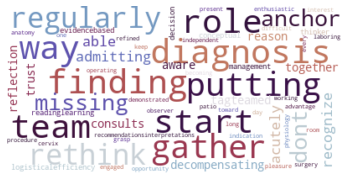

Words in top 100 most common words from LOW SCORING evaulations that are unique to MALES


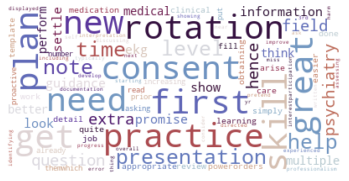

In [229]:
# common & unique words between female / male students LOW evals

commonl = words_fml[(words_fml.female_freq.notnull()) & (words_fml.male_freq.notnull())]
uniquel = words_fml[(words_fml.female_freq.isna()) | (words_fml.male_freq.isna())]
unique_fl = uniquel[uniquel.female_freq.notnull()]
unique_ml = uniquel[uniquel.male_freq.notnull()]

unique_fl.drop(columns = ['male_freq', 'rank_m'], inplace = True)
unique_ml.drop(columns = ['female_freq', 'rank_f'], inplace = True)

# Words unique to FEMALES' evaluations (in most 100 common words) LOW EVALS
comment = " ".join(comment for comment in unique_fl.word)
wordcloud = WordCloud(max_font_size = 40,
                      collocations = False, 
                      stopwords = stopwords,
                      margin = 0, 
                      background_color = 'white', 
                      colormap = 'twilight').generate(comment)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
print('Words in top 100 most common words from LOW SCORING evaluations that are unique to FEMALES')
plt.show()

# Words unique to MALES' evaluations (in most 100 common words) LOW EVALS
comment = " ".join(comment for comment in unique_ml.word)
wordcloud = WordCloud(max_font_size = 40,
                      collocations = False, 
                      stopwords = stopwords,
                      margin = 0, 
                      background_color = 'white', 
                      colormap = 'twilight').generate(comment)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
print('Words in top 100 most common words from LOW SCORING evaulations that are unique to MALES')
plt.show()

In [273]:
# COUNT / PCT of FEMALES per course 
dffc = pd.DataFrame(dff.groupby('course').count().eval_id)
dffc.reset_index(inplace = True)
dffc.rename(columns = {'eval_id': 'female'}, inplace = True)
dffc['female_pct'] = dffc.female / dffc.female.sum()

# COUNT / PCT of MALES per course 
dfmc = pd.DataFrame(dfm.groupby('course').count().eval_id)
dfmc.reset_index(inplace = True)
dfmc.rename(columns = {'eval_id': 'male'}, inplace = True)
dfmc['male_pct'] = dfmc.male / dfmc.male.sum()

# format
pd.options.display.float_format = '{:.1%}'.format

# merge data
dfc = pd.merge(dffc, dfmc, on = 'course', how = 'inner')

dfc.rename(columns = {'female':'female_evals', 'male': 'male_evals'}, inplace = True)
print('Count of Evaluations per gender across course')
dfc

Count of Evaluations per gender across course


course  female_evals  female_pct  male_evals  male_pct
0         Ambulatory            57       12.9%         119     14.9%
1    Family Medicine            50       11.3%         127     15.9%
2  Internal Medicine            92       20.8%         141     17.7%
3          Neurology            26        5.9%          50      6.3%
4         Obstetrics            47       10.6%          50      6.3%
5         Pediatrics            49       11.1%          93     11.7%
6         Psychiatry            64       14.5%         140     17.5%
7            Surgery            57       12.9%          78      9.8%

# SQL Lite

As I was exploring different techniques, I came across a suggestion to utilize SQL Lite (<a href="https://www.oreilly.com/library/view/blueprints-for-text/9781492074076/ch04.html">Albrecht, Ramachanran, & Winkler</a>). I kept this in my final list of steps because it provided additional flexibility to revert back to earlier iterations of the dataframe.

In [50]:
data.columns

Index(['eval_id', 'student_id', 'gender', 'course', 'preceptor', 'epa_number',
       'display_label', 'rating_score', 'rating_label', 'comments', 'words',
       'comments_clean'],
      dtype='object')

In [51]:
column_map = {'course' : 'course', 'student_id' : 'student', 'gender' : 'gender', 'display_label' : 'competency', 
              'rating_label' : 'rating', 'rating_score' : 'rating_score', 'comments': 'comments'
              }

# define remaining columns
columns = [c for c in column_map.keys() if column_map[c] != None]

# select and rename those columns
eval_data = data[columns].rename(columns = column_map)

In [52]:
eval_data.head(3)

course student gender  \
0  Pediatrics     855      M   
1  Pediatrics     855      M   
2  Pediatrics     855      M   

                                          competency  \
0  Gather a History and Perform a Physical Examin...   
1  Provide an Oral Presentation of a Clinical Enc...   
2  Prioritize a Differential Diagnosis Following ...   

                                   rating rating_score  \
0  I had to prompt them from time to time            3   
1  I had to prompt them from time to time            3   
2   I needed to be available just in case            4   

                                            comments  
0  Work on your interview structure. Keep it cons...  
1  Develop ED focused presentation skills by pres...  
2          Watch as many physical exams as possible

In [53]:
import sqlite3
# https://www.oreilly.com/library/view/blueprints-for-text/9781492074076/ch04.html

db_name = 'evaluation.db'
con = sqlite3.connect(db_name)
eval_data.to_sql('eval', con, 
            index = False, 
            if_exists = 'replace')
con.close()

In [54]:
con = sqlite3.connect(db_name)
sample_evals = pd.read_sql("select competency, rating, comments from eval", con)
con.close()

# Sentiment analysis

I used Spacy, Textacy, and TextBlob for sentiment analysis and named entity recognition (NER).

In [55]:
texts = data['comments'].str.split('\n')

string = ' '.join([str(item) for item in texts])

blob = TextBlob(string)

doc = nlp(string)

In [56]:
from textacy.extract import keyterms as kt

# get key terms
kt.textrank(doc, normalize = "lemma", topn = 10)

[('good patient presentation', 0.012947087402218557),
 ('good physical exam finding', 0.009981996926611293),
 ('overall good note writing skill', 0.009370484208071538),
 ('patient present unique opportunity', 0.009264167120135116),
 ('excellent patient evaluation', 0.008705778054775825),
 ('great patient', 0.00864396169398557),
 ('good presentation skill', 0.008578138426080184),
 ('patient need', 0.008430699419498502),
 ('patient information', 0.008412780340643161),
 ('patient history', 0.008399879531708655)]

I extracted the polarity of statements in the dataset, using a random sample.

In [57]:
# https://towardsdatascience.com/having-fun-with-textblob-7e9eed783d3f

sample = sample_evals.sample(frac = 0.8, replace = False, random_state = 1)

def detect_polarity(text):
    return TextBlob(text).sentiment.polarity

sample['polarity'] = sample.comments.apply(detect_polarity)

In [58]:
sample.head(10)

competency  \
119   Recommend and Interpret Common Diagnostic and ...   
202   Collaborate as a Member of an Interprofessiona...   
482   Collaborate as a Member of an Interprofessiona...   
403   Prioritize a Differential Diagnosis Following ...   
259   Gather a History and Perform a Physical Examin...   
167   Gather a History and Perform a Physical Examin...   
940   Provide an Oral Presentation of a Clinical Enc...   
679   Document a Clinical Encounter in the Patient R...   
1076  Document a Clinical Encounter in the Patient R...   
991   Prioritize a Differential Diagnosis Following ...   

                                      rating  \
119   I had to prompt them from time to time   
202    I needed to be available just in case   
482    I needed to be available just in case   
403   I had to prompt them from time to time   
259               I did not need to be there   
167               I did not need to be there   
940    I needed to be available just in case   
679    I needed to be available just in case   
1076              I did not need to be there   
991    I needed to be available just in case   

                                               comments  polarity  
119                                          doing well  0.000000  
202                               Experience with time   0.000000  
482   Continue seeing patients and developing differ...  0.000000  
403   Continue to familiarize yourself with DSM5 cri... -0.118750  
259                                         No comments  0.000000  
167                Good recognition of MSK and good DPX  0.700000  
940   Great at obtaining relevant information. Just ...  0.225455  
679                             Continue to practice.    0.000000  
1076  Excellent documentation of your call with her ...  0.300000  
991          Did well on a fairly complicated patient.  -0.500000

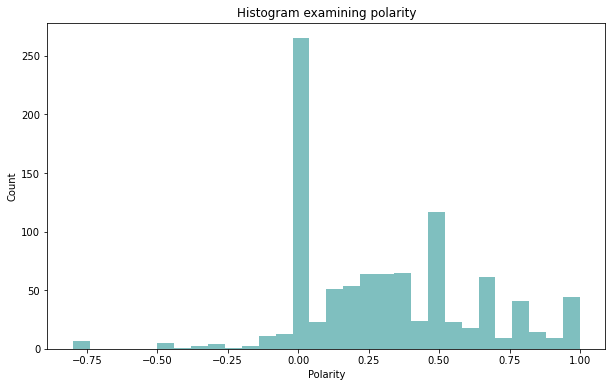

In [59]:
num_bins = 30
plt.figure(figsize = (10,6))
n, bins, patches = plt.hist(sample.polarity, num_bins, facecolor = 'teal', alpha = 0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram examining polarity')
plt.show();

In [61]:
os.getcwd()

'C:\\Users\\clark\\Documents\\LOCAL_REPOSITORY_LOCATION\\612_TextMining'

It seems to be correctly flagging words like "excellent", and it's interesting to see that these are associated with the highest possible rating (_I did not need to be there_).

In [62]:
sample[sample.polarity > .30].head(5)

competency  \
167   Gather a History and Perform a Physical Examin...   
1076  Document a Clinical Encounter in the Patient R...   
65    Form Clinical Questions and Retrieve Evidence ...   
831   Gather a History and Perform a Physical Examin...   
815   Prioritize a Differential Diagnosis Following ...   

                                      rating  \
167               I did not need to be there   
1076              I did not need to be there   
65                I did not need to be there   
831   I had to prompt them from time to time   
815               I did not need to be there   

                                               comments  polarity  
167                Good recognition of MSK and good DPX  0.700000  
1076  Excellent documentation of your call with her ...  0.300000  
65                                good job on this task  0.700000  
831   Continue to synthesize patient information as ...  0.366667  
815    creates excellent differentials and is a very...  0.760000

Neutral statements are more mixed in quality--again, _no comments_ surfaces. It's not surprising to see that ratings skew a little high, in general.

In [63]:
sample[sample.polarity == 0].head(5)

competency  \
119  Recommend and Interpret Common Diagnostic and ...   
202  Collaborate as a Member of an Interprofessiona...   
482  Collaborate as a Member of an Interprofessiona...   
259  Gather a History and Perform a Physical Examin...   
679  Document a Clinical Encounter in the Patient R...   

                                     rating  \
119  I had to prompt them from time to time   
202   I needed to be available just in case   
482   I needed to be available just in case   
259              I did not need to be there   
679   I needed to be available just in case   

                                              comments  polarity  
119                                         doing well       0.0  
202                              Experience with time        0.0  
482  Continue seeing patients and developing differ...       0.0  
259                                        No comments       0.0  
679                            Continue to practice.         0.0

In [64]:
sample[sample.polarity < 0].head(5)

competency  \
403   Prioritize a Differential Diagnosis Following ...   
991   Prioritize a Differential Diagnosis Following ...   
575   Recommend and Interpret Common Diagnostic and ...   
1196  Provide an Oral Presentation of a Clinical Enc...   
777   Provide an Oral Presentation of a Clinical Enc...   

                                      rating  \
403   I had to prompt them from time to time   
991    I needed to be available just in case   
575    I needed to be available just in case   
1196   I needed to be available just in case   
777   I had to prompt them from time to time   

                                               comments  polarity  
403   Continue to familiarize yourself with DSM5 cri...  -0.11875  
991          Did well on a fairly complicated patient.   -0.50000  
575   at expected level, just continue to read and s...  -0.10000  
1196  Very clear presentation on an evasive patient....  -0.04250  
777   when there is a missing piece of information o...  -0.10000

In [65]:
# removing due to lack of results

# # https://stackoverflow.com/questions/67983109/how-can-i-pass-table-or-dataframe-instead-of-text-with-entity-recognition-using
# def get_entities(x):
#     result = {}
#     doc = nlp(x)
#     for ent in doc.ents:
#         result[ent.label_] = ent.text
#     return result

# ent_matches = data['comments'].apply(get_entities)

# ent_matches

0                                          {}
1                       {'ORG': 'Develop ED'}
2                                          {}
3       {'DATE': 'just beginning third year'}
4                                          {}
                        ...                  
1235                        {'DATE': 'daily'}
1236                                       {}
1237                                       {}
1238                                       {}
1239                                       {}
Name: comments, Length: 1240, dtype: object

In [66]:
sample.describe()

polarity
count  992.000000
mean     0.306842
std      0.325759
min     -0.800000
25%      0.000000
50%      0.275000
75%      0.500000
max      1.000000

I used a few sample phrases to train a small model for sentiment analysis.

In [85]:
from textblob import classifiers

training = [
    ('great job especially beginning third year', 'pos'), 
    ('wonderful building rapport', 'pos'),
    ('handled communication non English speaking family well', 'pos'),
    ('integrates strong organization skills complex scenario', 'pos'),
    ('thorough physical exam Well done', 'pos'),
    ('Great job', 'pos'),
    ('Good job. Continue good work', 'pos'),
    ('Great work, especially early in third year!' , 'pos'),
    ('Presentations could concise organized No need repeat studies imaging already discussed prior days', 'neg'),
    ('Should work on being more methodical in collecting information and presenting so nothing is forgotten or missed.', 'neg'),
    ('Work overall organization material want cover slow slightly allow audience follow discussion readily.', 'neg'),
    ('Great thoughts presented', 'pos'),
    ('Good critical thinking differential diagnosis presentation', 'pos'),
    ('More work needed. Continue reading and practicing.', 'neg'),
    ('Continue work on your knowledge base.', 'neg'),
    ('Asked appropriate questions, but would encourage him to closely observe more and ask only a few key, critical questions especially during surgery when the surgeons may be concentrating.', 'neg'), 
    ('Keep it consistent so you don’t forget things.', 'neg'), 
    ('the plan probably couldve been more streamlined by cutting out the old stuff', 'neg'), 
    ('Increase efficiency patient using interpreter requires intentional  rushed interaction.', 'neg'),
    ('Watch as many physical exams as possible.', 'neg'), 
    ('No comment.', 'neg'),
    ('Bad job.', 'neg'),
    ('needs continue work redirecting patient finishing interview timely manner. This comes with practice.', 'neg')]

classifier = classifiers.NaiveBayesClassifier(training)


Then, performing a quick test to see if the model can correctly flag the statement below as positive.

In [89]:
classifier.classify('')

'pos'

Reviewing the output, it does a pretty good job, but providing it with richer training data may improve future results.

In [90]:
# https://textblob.readthedocs.io/en/dev/classifiers.html
from textblob import Blobber
from textblob.taggers import NLTKTagger
from textblob.tokenizers import SentenceTokenizer

testing = data['comments'].str.split('\n')

test_data = ' '.join([str(item) for item in testing])

tb = Blobber(pos_tagger = NLTKTagger(), tokenizer = SentenceTokenizer(), classifier = classifier)

blob = tb(test_data)

for s in blob.sentences:
    print(s)
    print(s.classify())

['Work on your interview structure.
neg
Keep it consistent so you don’t forget things.
neg
Obtain history then past medical, surgical, social meds and allergies.
pos
Keep interviewing patients so you can practice. ']
neg
['Develop ED focused presentation skills by presenting the pertinent positives and negatives for each complaint.']
pos
['Watch as many physical exams as possible '] ['Should work on being more methodical in collecting information and presenting so nothing is forgotten or missed.
neg
He is doing a great job, especially for just beginning third year!']
pos
["Did well reorganizing the assessment by problem, the plan probably could've been more streamlined by cutting out the old stuff"] ["I think it's great to get involved with what physical therapy was doing.
neg
Also did well reaching out to ENT. "]
pos
['Present, scrubbed and engaged for a hysterectomy.
pos
Asked appropriate questions, but would encourage him to closely observe more and ask only a few key, critical ques

pos
['Great interview!
pos
I appreciated how thorough you were and your line of questioning was well done.
pos
Also liked how you were able to connect with patient and made empathic statements.
neg
She seemed comfortable with you and responded well to the interview.
neg
As you already saw since you were there in the room, there were only a few follow up questions I had for her at the end regarding clarifying things in her timeline, trying to get a good feel for the pattern of her symptoms, and some little things in her psych & social histories. ']
neg
['Student was able to handle this difficult patient well.
pos
I have no large concerns about whether Student can meet with difficult patients in the future.']
pos
['Student was able to gather relevant information and develop a good rapport with the patient.
neg
As with all medical students, time will allow him to hold a more focused interview.']
neg
['good job taking initiative'] ['You did great!
pos
Continue seeing difficult patients and

['Remember social determinates of health, insurance, \'side benefits"'] ['Consider special tests'] ['sick/not sick, remember red flags'] ['Doing well at taking initiative and responsibility '] ['Good initial presentation.
pos
Continue to develop familiarity with the psychiatric evaluation as discussed this week.']
neg
['The medical student interviewed an older gentleman with a major neurocognitive disorder.
pos
The interview was organized well, and it gave the student the opportunity to identify a correct differential diagnosis that included the most relevant possibilities.
neg
In order to become more independent, the student should continue and practice the interviewing and presentation skills with a variety of psychiatric patients.']
neg
['Good differential considerations for pt with complex set of symptoms.
pos
Continue to develop familiarity with trauma related anxiety disorders, mood disorders, substance use disorders, personality disorders and eating disorders.']
neg
['In patient

pos
['No comments'] ['No comments'] ['No comments'] ['No comments'] ['No comments'] ['No comments'] ['No comments'] ['No comments'] ['No comments'] ['Nice write up for a complex patient '] ['Continue to expand knowledge base'] ['Solid presentation skills'] ['Excellent job'] ['He did an excellent job in clinic.
pos
He was able to evaluate a complicated (I think all late CKD patients are relatively complicated) patient, on his own and give a very coherent presentation with a complete plan of what to do.
neg
He presented the patient in a very organized, thorough manner,  He summarized the problems.
pos
He anticipated problems we might have with recommended treatment plans and recommended possible plans to do should this complications arise.
neg
I was also very impressed with his well-thought out note.']
pos
['Just make sure to update changes from the day before.
pos
Update physical exam'] ['Presenting in a more organized manner.
pos
overall doing very well'] ['Good organization and flow o

pos
try to assess JVD for CHF patients daily if possible.
pos
ok to nicely tell patient that is rambling that you have to go.
neg
Total interview and exam took a little long, try to keep in 5-10 minute range, yours took 14 minutes. ']
pos
['for your documentation today, would recommend still having a chief complaint at the top of your note, otherwise good job'] ['thorough h&p.
pos
he can work on efficiency, especially in the setting of a busy clinic. ']
neg
['work on establishing a rapport with patients and becoming more efficient'] ['he will become more independent as he gets more experience'] ["Student was able to come up with a differential list of at least three conditions related to the patient's chief complaint.
neg
Reading more on specific conditions may allow him to have a more complete list"] ["Good job taking a complete history and physical.
neg
There were some history questions very specific to the patient's chief complaint that Student missed, but this was expected given hi

pos
I think simply more exposure to the patients is key, and she will do well (regardless of the specialty or clinical subject matter).']
neg
['Excellent student.
pos
Asking good questions.
pos
Has good knowledge of common genetic syndrome.']
pos
['Did a great job!']
pos
['Is great for her level of training'] ['Practice - everyone needs this!']
pos
['No improvement needed. ']
pos
['Student provided appropriate DF dx for SOB '] ['Practice - takes a lot of repetition to fine tune exam.
pos
Keep reading. ']
pos
['Organized and well thought A&P.
pos
Could improve more on HPI'] ['Practice..'] ['More patients to practice on. ']
neg
['No comments'] ['Nice job with your note!
pos
Like we discussed I just cut out some of the longer sentences so it was faster to read.
neg
The only other thing is to make sure you read your notes really carefully when you copy them forward.
neg
On Friday your note still said “ugi tomorrow” even though now it was today, and a couple other little things like that'] 

neg
[' did an excellent job!
pos
I have no specific critiques-- just keep reading, learning, and expanding your knowledge base and experience (as we all are!)']
neg
['was able to develop differential but needs to perhaps gain more data in history to help support differential '] [' did a great job today interviewing patients and counseled them on their eating habits.
neg
has a good understanding of managing DM with medications as well as lifestyle changes. ']
pos
['He was independent'] ['Already very independent.
pos
Good instincts and limited guidance needed.']
pos
['Used evidence based med to answer questions about patient care .
pos
Great job'] ['Very interested learner.
pos
Did not work with him long enough to make complete eval/recommendations.
pos
Interacts well with patients.']
pos
['none, he is fantasit c'] ['Already very independent.
pos
Thorough and reliable interviews and exams. ']
pos
['Great work!
pos
After one more observation I would say he could go ahead and I would chec

pos
We discussed having a broadened differential prior to walking in so you can ask about other diagnoses that pertain to volume overload (urine frequency, foam etc).
neg
when discussing meds, use both notes to enhance recognition // You exposed the skin appropriately for the chest and lung exam.
neg
This was a challenging setting as the patient was on a gurney  but if able to, check for scrotal edema for volume overload.
neg
// overall good rapport.
pos
In time you will be able to make it more conversational than check-list style.
neg
// In this situation I wouldn\'t expect you to sit down as it was a narrow hallway but of course in general try to sit down as much as possible.']
neg
['thinking about what the broad differentials are for the chief complaint that the patient is presenting with, and gearing your question (to the patient) based on your differential in order to help guide you towards the most likely diagnoses and what treatment plan you want to go towards. ']
neg
['Student 

neg
['Excellent work.
pos
Keep on the same path'] ['Keep working on physical exam techniques'] ['Will did a great job communicating the information regarding this patient and making an accurate clinical assessment.']
neg
['No issues on shift.
pos
Well prepared.']
pos
['Will did well with this age group.
pos
It was a complicated patient and he was quite engaged.  ']
neg
['Nothing.
pos
Already very adept at patient evaluation and presentation! ']
pos
['when there is a missing piece of information or understanding, skip explanations of why missed to closing the gap with research (eg, asking the patient for clarification or medical record search)'] ['Already independent.
neg
Brings appropriate data to the forefront for synthesis.
pos
Exam supports diagnosis. ']
pos
['Continue to work on delving into his assessments and plans without prompting '] ['Overall a really great job!! ']
pos
['Keep practicing'] ['Clear and concise presentation on an established patient. ']
neg
['Doing a great job, 

neg
He made good connection with the patient asking about his past occupation and had a good lead in to other parts of the social history.
neg
|| sit down when you can, close the door to eliminate noises.']
neg
["Student is impressively advanced for a third year medical student.
pos
I would place him as a mid-year fourth year medical student in regards to his knowledge, work efficiency, and synthesis.
neg
In regards to a patient with extensive PMH including CAD, renal transplant, sickle cell anemia with transfusion monthly, pulmonary HTN, cirrhosis, uncontrolled insulin dependent diabetes he was able to filter out the patient's complaints in relation to all of her active issues.
neg
In regards to areas of improvement, I would recommend that Student continue reading on topics that he is unfamiliar with, but by no means do I believe that he lacks a general fund of knowledge."]
neg
['EBM assignment: Good PICO.
pos
It’s harder to formulate this with a 2x2 design.
neg
Technically PICO shoul

pos
Respectful and professional.']
pos
['Good job!
pos
Just remember to not pre maturely marrow your differential until you obtain all of the information. ']
neg
['Good job! ']
pos
['Student is new to the field of psychiatry and this is his first rotation hence he will need some extra guidance to get settle.
neg
Shows great promise'] ['Student is new to the field of psychiatry and this is his first rotation hence he will need some extra guidance to get settle.
neg
Shows great promise'] ['Student is new to the field of psychiatry and this is his first rotation hence he will need some extra guidance to get settle.
neg
Shows great promise'] ['Student is new to the field of psychiatry and this is his first rotation hence he will need some extra guidance to get settled.
neg
Shows great promise!']
pos
['He does interview indipendently and open to feedback - able to come up with a couple of differential diagnosis - makes insightful comments '] ['Continue formulate Ample DIfferential diagnosis

pos
['Reading more.
pos
(The same I would say for all students regardless), doing great so far!']
pos
['Very proactive student.
pos
She is doing an excellent job. ']
pos
['Good performance '] ['Excellent student.
pos
Functions at a AI or early resident level. ']
pos
['Read more (I say this to all students regardless of progress)'] ['Read more (I literally tell every student this regardless of progress)'] ['Student performs at the level of at least an AI.
neg
Her note had all the pertinent findings and she had a thorough assessment and accurate plan. ']
neg
["Student was the most active participant in the code blue that occured on Tuesday.
pos
She was the only team member able to obtain a manual blood pressure, she helped the team establish venous access and helped administer fluids to stabilize the patient.
neg
She did not leave the patient's side until he was transferred from the unit."]
pos
['good job doing a thorough h and p, often will fill in the missing blanks to make a comprehen

pos
["Very clear presentation on an evasive patient.
pos
May articulate the different possibilities of what is going on in the assessment - he's depressed and wants to die and is lying to us, he WAS depressed and WANTED to die when he was drunk, but not now, etc."]
neg
['Just continue your current active approach to  learning'] ['Excellent documentation of a clinical encounter.
neg
All vital aspects were included with appropriate amount of relevant detail!
pos
Keep up the good work!']
pos
['Student is working toward becoming independent '] ['As discussed, helpful to think broadly about differential for a chief presenting problem to maximize systematic consideration of possible causes.']
neg
['Focus on expanding a differential diagnosis rather than getting caught up in minute details.
pos
Begin to recognize that not all diagnoses are perfect'] ['Doing an amazing job as a 3rd year medical student.
pos
Her work is thoughtful and reliable.
pos
We loved working with her on the newborn team.

In [91]:
classifier.show_informative_features(10)

Most Informative Features
           contains(job) = True              pos : neg    =      3.0 : 1.0
    contains(especially) = True              pos : neg    =      2.1 : 1.0
         contains(Great) = False             neg : pos    =      1.4 : 1.0
          contains(work) = True              neg : pos    =      1.4 : 1.0
      contains(Continue) = True              neg : pos    =      1.3 : 1.0
           contains(job) = False             neg : pos    =      1.3 : 1.0
           contains(and) = False             pos : neg    =      1.3 : 1.0
      contains(critical) = True              pos : neg    =      1.3 : 1.0
            contains(in) = True              pos : neg    =      1.3 : 1.0
          contains(more) = False             pos : neg    =      1.3 : 1.0


# PCA with TextHero

In [92]:
import texthero as hero
import pandas as pd

df = data

df['tfidf'] = (
    data['comments']
    .pipe(hero.clean)
    .pipe(hero.tfidf)
)

df['kmeans_labels'] = (
    df['tfidf']
    .pipe(hero.kmeans, n_clusters = 5)
    .astype(str)
)

df['pca'] = df['tfidf'].pipe(hero.pca)

hero.scatterplot(df, 'pca', color = 'kmeans_labels', title = 'K-means')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:786: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  warnings.warn("'precompute_distances' was deprecated in version "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


# Entity recognition in Spacy

This aspect of the project took a few iterations. I noticed that Spacy would correctly identify one, or sometimes a few instances of a name (e.g., _Amanda_, but wouldn't flag every instance. There were some misclassifications, like _H&P_ (medical shorthand for "history and physical"), which Spacy identified as an organization.

In the future, I plan to further refine the pre-processing options to replace common medical shorthand with full words. Additionally, I'd like to explore the Spacy library to customize and improve on the model's ability to recognize entities in the data. 

In [93]:
from spacy import displacy

# nlp = spacy.load('en_core_web_trf') # did not work

# spacy.displacy.render(doc, style = 'ent')

In [94]:
# predicting named entities
for ent in doc.ents:
    print(ent.text, ent.label_)

just beginning third year DATE
a new third year DATE
CT ORG
the week DATE
cont GPE
today DATE
Peds ENT ORG
NV ORG
HPI ORG
morning TIME
ROS ORG
two CARDINAL
HPI ORG
OSH ORG
ekgs ORG
MD GPE
MD GPE
today DATE
Easy PERSON
1 CARDINAL
one CARDINAL
ROM ORG
CV GPE
MSK ORG
DPX ORG
this week DATE
Psychoanalytic Diagnosis ORG
3 CARDINAL
one week DATE
the day DATE
One CARDINAL
H & Ps ORG
his 2nd week DATE
UTI ORG
first ORDINAL
3rd ORDINAL
first ORDINAL
the week DATE
first ORDINAL
this week DATE
the day before DATE
CSF ORG
Emporia GPE
VCU ORG
nine-year-old DATE
just one week DATE
first ORDINAL
2 weeks DATE
yesterday DATE
today DATE
today DATE
ER ORG
first ORDINAL
first ORDINAL
first ORDINAL
overnight TIME
few seconds TIME
JVD PERSON
CHF ORG
daily DATE
5-10 minute TIME
14 minutes TIME
today DATE
h&p GPE
at least three CARDINAL
first ORDINAL
5/21 CARDINAL
first ORDINAL
5/21 CARDINAL
DSM 5 ORG
DSM5 NORP
SOAP ORG
first ORDINAL
HPI ORG
first ORDINAL
GI ORG
A&P ORG
SBP ORG
SBP ORG
the past several weeks 

In [95]:
list(extract.keyword_in_context(doc, 'good', window_width = 25, pad_context = True))

[('ther students. He showed ', 'good', ' understanding of a parti'),
 ("y and exam. '] ['Doing a ", 'good', " job'] ['Doing a good job"),
 ("g a good job'] ['Doing a ", 'good', " job'] ['continuing to do"),
 ("job'] ['continuing to do ", 'good', " work'] ['The medical stu"),
 ('e was able to identify a ', 'good', ' differential diagnosis, '),
 ('patient\'s baseline. "] [\'', 'Good', ' differential dx. Continu'),
 ("ifferential and plan'] ['", 'Good', ' recommendation of diagno'),
 ("panding differential'] ['", 'Good', ' interpretation of tests,'),
 (" the situation '] ['Very ", 'good', ' job approaching the toug'),
 ('est case of all of them, ', 'good', ' plans and assessment; wo'),
 ('ts in clinic today. Very ', 'good', ' rapport with patients an'),
 ("tients. '] ['keep up the ", 'good', " work'] ['good job on thi"),
 ("eep up the good work'] ['", 'good', " job on this task'] ['Con"),
 ("uerades in many ways'] ['", 'Good', " history taking'] ['MSK, "),
 ("sider underlying ...'] ['", '

In [96]:
nlp.analyze_pipes()

{'summary': {'tok2vec': {'assigns': ['doc.tensor'],
   'requires': [],
   'scores': [],
   'retokenizes': False},
  'tagger': {'assigns': ['token.tag'],
   'requires': [],
   'scores': ['tag_acc'],
   'retokenizes': False},
  'parser': {'assigns': ['token.dep',
    'token.head',
    'token.is_sent_start',
    'doc.sents'],
   'requires': [],
   'scores': ['dep_uas',
    'dep_las',
    'dep_las_per_type',
    'sents_p',
    'sents_r',
    'sents_f'],
   'retokenizes': False},
  'attribute_ruler': {'assigns': [],
   'requires': [],
   'scores': [],
   'retokenizes': False},
  'lemmatizer': {'assigns': ['token.lemma'],
   'requires': [],
   'scores': ['lemma_acc'],
   'retokenizes': False},
  'ner': {'assigns': ['doc.ents', 'token.ent_iob', 'token.ent_type'],
   'requires': [],
   'scores': ['ents_f', 'ents_p', 'ents_r', 'ents_per_type'],
   'retokenizes': False}},
 'problems': {'tok2vec': [],
  'tagger': [],
  'parser': [],
  'attribute_ruler': [],
  'lemmatizer': [],
  'ner': []},
 'att